# Predicting House Prices with Apache Spark

- [1.- Understanding the Data Set](#1) 
- [2.- Import](#2)
- [3.- Creating the Spark Session](#3)
- [4.- Load the data from a file into a DataFrame](#4)
- [5.- Data Exploration](#5)
- [6. Data Preprocessing](#6)

# 1
### Understanding the Data Set

Data set:https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

**Longitude:** refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

**Latitude:** refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

**Housing Median Age:** is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values

**Total Rooms:** is the total number of rooms in the houses per block group

**Total Bedrooms:** is the total number of bedrooms in the houses per block group

**Population:** is the number of inhabitants of a block group

**Households:** refers to units of houses and their occupants per block group

**Median Income:** is used to register the median income of people that belong to a block group

**Median House Value:** is the dependent variable and refers to the median house value per block group

# 2
### Import 

In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# 3
### Creating the Spark Session

In [6]:
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()
spark

23/10/26 12:47:39 WARN Utils: Your hostname, abel-Surface-Pro resolves to a loopback address: 127.0.1.1; using 172.17.0.1 instead (on interface docker0)
23/10/26 12:47:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/26 12:47:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/26 12:47:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [8]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/home/patricia/miniconda3/envs/pyspark/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# 4 
### Load the data from a file into a DataFrame

In [16]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("median_age", FloatType(), nullable=True),
    StructField("total_rooms", FloatType(), nullable=True),
    StructField("total_bdrms", FloatType(), nullable=True),
    StructField("population", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [17]:
# Load housing data
housing_df = spark.read.csv(path='./data/cal_housing.data', schema=schema).cache()


In [18]:
# Insepct first five rows
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, median_age=41.0, total_rooms=880.0, total_bdrms=129.0, population=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, median_age=21.0, total_rooms=7099.0, total_bdrms=1106.0, population=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, median_age=52.0, total_rooms=1467.0, total_bdrms=190.0, population=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, median_age=52.0, total_rooms=1274.0, total_bdrms=235.0, population=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, median_age=52.0, total_rooms=1627.0, total_bdrms=280.0, population=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [19]:
# Show first five rows
housing_df.show(5)

+-------+-----+----------+-----------+-----------+----------+--------+------+--------+
|   long|  lat|median_age|total_rooms|total_bdrms|population|houshlds|medinc|   medhv|
+-------+-----+----------+-----------+-----------+----------+--------+------+--------+
|-122.23|37.88|      41.0|      880.0|      129.0|     322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|      21.0|     7099.0|     1106.0|    2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|      52.0|     1467.0|      190.0|     496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|      52.0|     1274.0|      235.0|     558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|      52.0|     1627.0|      280.0|     565.0|   259.0|3.8462|342200.0|
+-------+-----+----------+-----------+-----------+----------+--------+------+--------+
only showing top 5 rows



In [20]:
# show the dataframe columns
housing_df.columns

['long',
 'lat',
 'median_age',
 'total_rooms',
 'total_bdrms',
 'population',
 'houshlds',
 'medinc',
 'medhv']

In [21]:
# show the schema of the dataframe
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bdrms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



# 5
### Data Exploration

In [22]:
# run a sample selection
housing_df.select('population','total_bdrms').show(10)

+----------+-----------+
|population|total_bdrms|
+----------+-----------+
|     322.0|      129.0|
|    2401.0|     1106.0|
|     496.0|      190.0|
|     558.0|      235.0|
|     565.0|      280.0|
|     413.0|      213.0|
|    1094.0|      489.0|
|    1157.0|      687.0|
|    1206.0|      665.0|
|    1551.0|      707.0|
+----------+-----------+
only showing top 10 rows



#### 5.1 Distribution of the median age of the people living in the area:

In [25]:
# groupBy dt by median_age and see the distribution
result_df = housing_df.groupBy('median_age').count().sort("median_age",ascending = False)

In [26]:
result_df.show(10)

+----------+-----+
|median_age|count|
+----------+-----+
|      52.0| 1273|
|      51.0|   48|
|      50.0|  136|
|      49.0|  134|
|      48.0|  177|
|      47.0|  198|
|      46.0|  245|
|      45.0|  294|
|      44.0|  356|
|      43.0|  353|
+----------+-----+
only showing top 10 rows



<Axes: xlabel='median_age'>

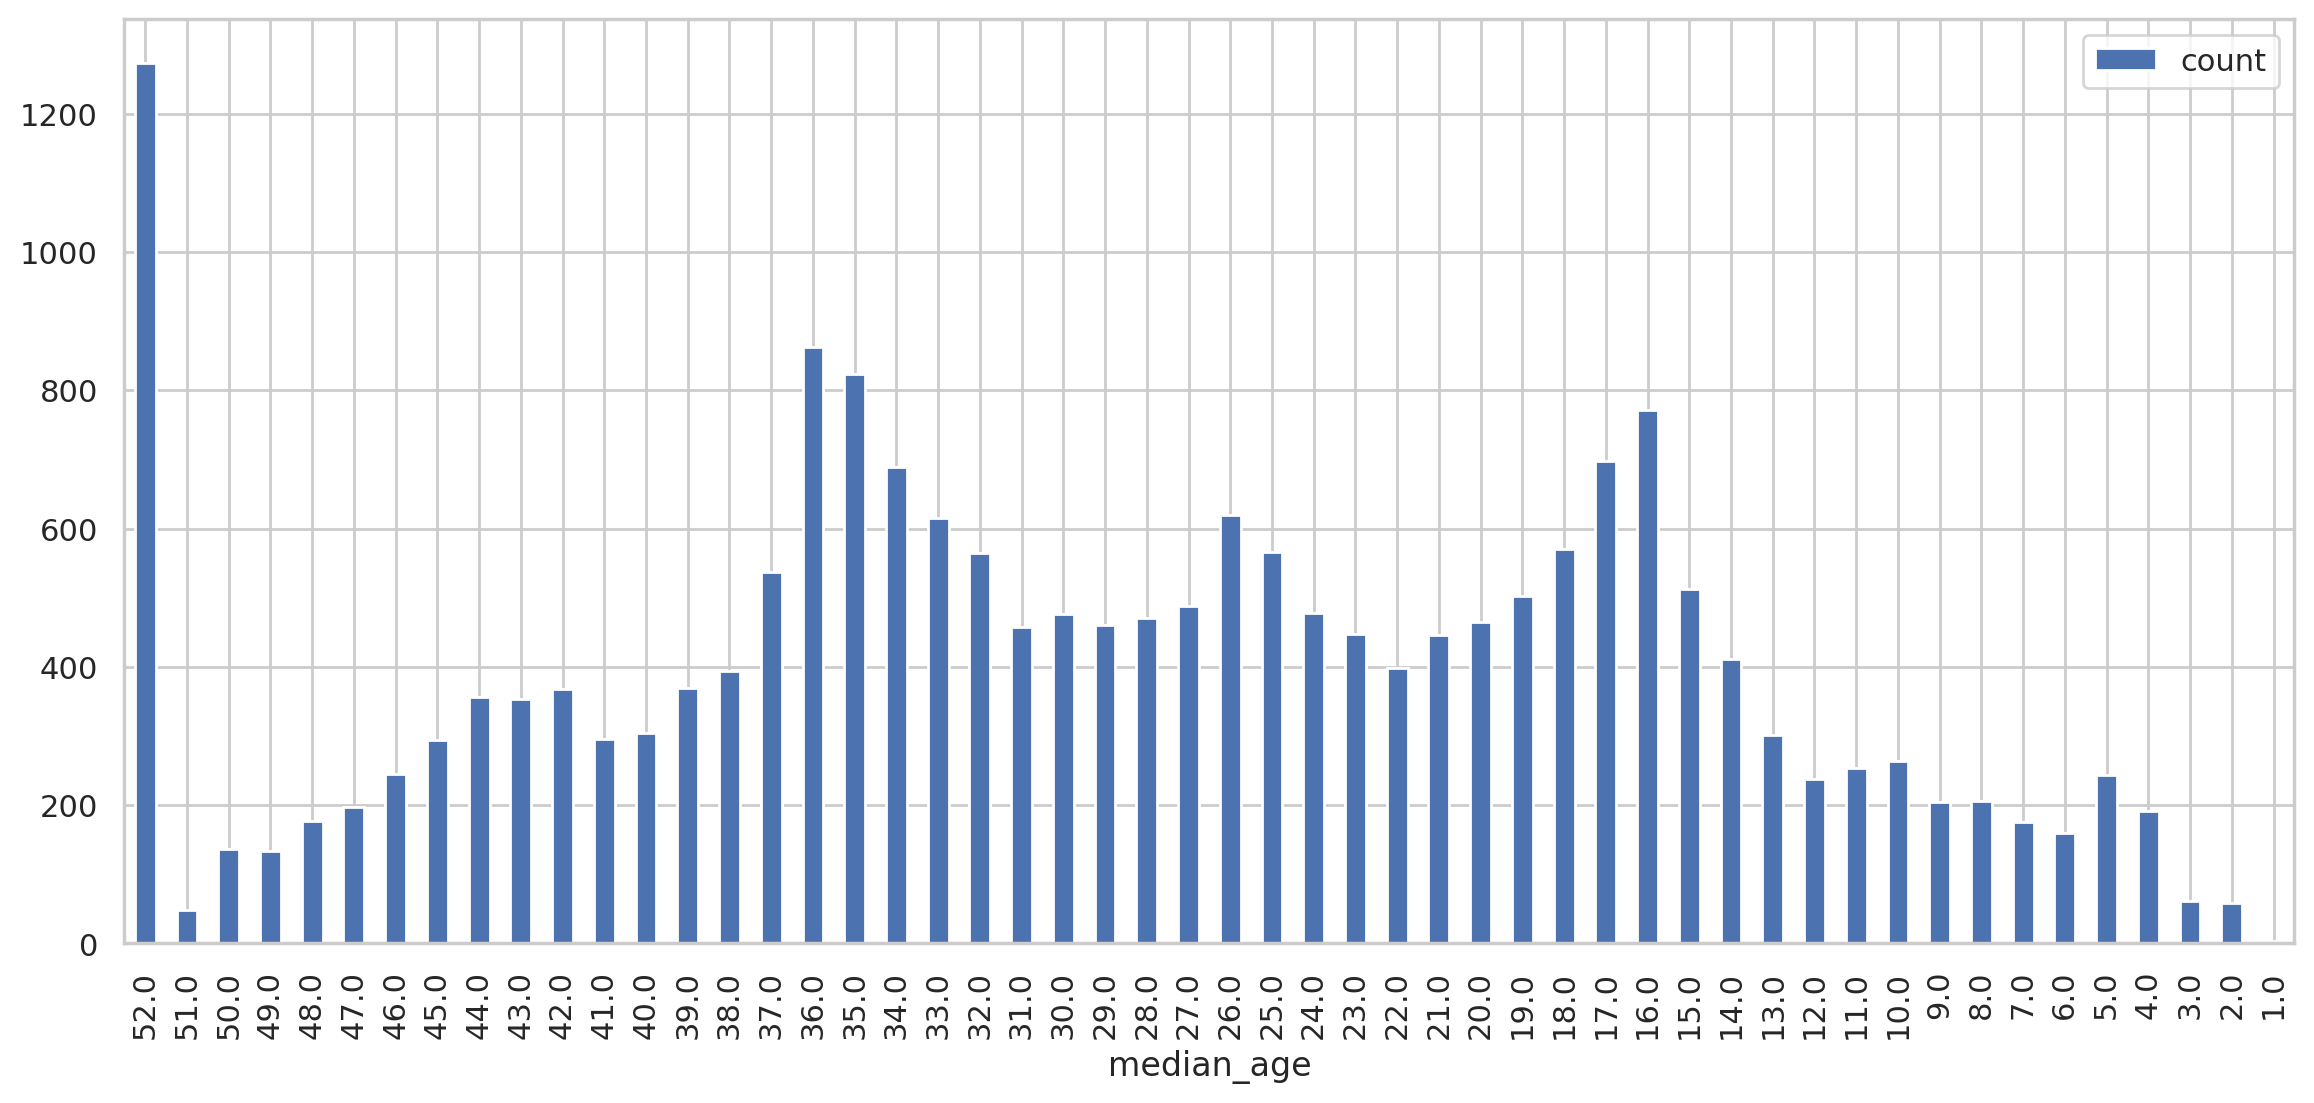

In [27]:
result_df.toPandas().plot.bar(x='median_age',figsize=(14,6))

Most of the residents are either in their youth or they settle here during their senior years. Some data are showing median age < 10 which seems to be out of place.

#### 5.2 Summary Statistics:

In [29]:
housing_df.describe().show()

23/10/26 13:04:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|               long|              lat|        median_age|       total_rooms|      total_bdrms|        population|         houshlds|            medinc|             medhv|
+-------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|            20640|             20640|            20640|             20640|             20640|
|   mean|-119.56970444871473|35.63186143109965|28.639486434108527|2635.7630813953488|537.8980135658915|1425.4767441860465|499.5396802325581|3.8706710030346416|206855.81690891474|
| stddev|  2.003531742932898|2.135952380602968| 12.58555761211163|2181.6152515827944| 421.247905943133|  

In [30]:
housing_df.describe().select(
    "summary",
    F.round("median_age",4).alias('median_age'),
    F.round('total_rooms',4).alias('total_rooms'),
    F.round('total_bdrms',4).alias('total_bdrms'),
    F.round('population',4).alias('population'),
    F.round("houshlds", 4).alias("houshlds"),
    F.round("medinc", 4).alias("medinc"),
    F.round("medhv", 4).alias("medhv")
).show()


+-------+----------+-----------+-----------+----------+--------+-------+-----------+
|summary|median_age|total_rooms|total_bdrms|population|houshlds| medinc|      medhv|
+-------+----------+-----------+-----------+----------+--------+-------+-----------+
|  count|   20640.0|    20640.0|    20640.0|   20640.0| 20640.0|20640.0|    20640.0|
|   mean|   28.6395|  2635.7631|    537.898| 1425.4767|499.5397| 3.8707|206855.8169|
| stddev|   12.5856|  2181.6153|   421.2479| 1132.4621|382.3298| 1.8998|115395.6159|
|    min|       1.0|        2.0|        1.0|       3.0|     1.0| 0.4999|    14999.0|
|    max|      52.0|    39320.0|     6445.0|   35682.0|  6082.0|15.0001|   500001.0|
+-------+----------+-----------+-----------+----------+--------+-------+-----------+



Look at the minimum and maximum values of all the (numerical) attributes. We see that multiple attributes have a wide range of values: we will need to normalize your dataset.

# 6
### Data Preprocessing